# EDA
**Data Source:** 
- Anomanlies_tracker.csv
- RDS database (connection credentials in .env file) that contains the financial reports in relational format

**Goal:** 
In this phase of the project, we will focus on ingesting the data, performing initial exploration, handling missing values, describing basic statistics, and conducting exploratory data analysis on the dataset generated during the preceding steps. This analysis aims to provide insights into the distribution of our variables, evaluate the balance among our classes, identify any necessary additional transformations for subsequent modeling stages, and ensure the suitability of both dependent and independent variables for our classification task.

More on SEC Filings: https://www.investopedia.com/articles/fundamental-analysis/08/sec-forms.asp#:~:text=The%20Securities%20and%20Exchange%20Commission,to%20invest%20in%20a%20company.

Other interesting links:
https://www.quora.com/Why-don-t-financial-data-match-SEC-10-K-filing-sometimes-I-added-link-in-comment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
import os

import sys
sys.path.append("/Users/zemariatrindade/BTS/Financy_App/Scripts_and_Data/venv/lib/python3.11/site-packages")
import psycopg2

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

#### Importing env variables

In [2]:
# Load environment variables from .env file
load_dotenv()

dbname = os.getenv('db_name')
user = os.getenv('db_username')
password = os.getenv('db_password')
host = os.getenv('db_host')
port = os.getenv('db_port')

## Data Ingestion

### Data source 1: Importing anomaly cases
found with research to annotate our dataset

In [3]:
anomalies_df = pd.read_csv("Anomalies_tracker.csv")
anomalies_df['cik_str'] = anomalies_df['cik_str'].astype(str).str.zfill(10)

In [4]:
anomalies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   cik_str                        227 non-null    object
 1   Scandal Year                   227 non-null    int64 
 2   Ticker                         227 non-null    object
 3   Company Name                   227 non-null    object
 4   Anomaly Ticker                 227 non-null    object
 5   earliest XBRL                  227 non-null    int64 
 6   XBRL available during anomaly  227 non-null    object
 7   10-Q/ 10-K available           227 non-null    object
 8   Decision                       227 non-null    object
 9   Detail - needs to be updated   227 non-null    object
dtypes: int64(2), object(8)
memory usage: 17.9+ KB


In [5]:
anomalies_df.head()

,cik_str,Scandal Year,Ticker,Company Name,Anomaly Ticker,earliest XBRL,XBRL available during anomaly,10-Q/ 10-K available,Decision,Detail - needs to be updated
0,0000002488,2009,AMD,ADVANCED MICRO DEVICES INC,AMD,2007,Yes,Yes,Yes,AMD (Antitrust lawsuit)
1,0000005272,2000,AIG,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)
2,0000005272,2001,AIG,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)
3,0000005272,2005,AIG,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)
4,0000005272,2000,AIG-PA,"AMERICAN INTERNATIONAL GROUP, INC.",AIG,2006,No,Yes,No,Accounting Fraud (Financial Misrepresentaion)


##### Making sure we don't have the same anomaly repeated
In the Anomalies_tracker, we had different tickers for the same cik number

In [6]:
anomalies_df = anomalies_df.drop_duplicates(subset=["cik_str","Scandal Year"])

##### filtering for the years and forms format where we have data to match

In [7]:
anomaly_cases = anomalies_df[(anomalies_df["Decision"]=="Yes")][["cik_str","Scandal Year","Anomaly Ticker"]]

In [8]:
print("Number of cases:", len(anomaly_cases))
print("Number of tickers:", len(anomaly_cases["Anomaly Ticker"].unique()))

anomaly_cases

Number of cases: 53
Number of tickers: 40


,cik_str,Scandal Year,Anomaly Ticker
0,0000002488,2009,AMD
16,0000019617,2006,JPM
17,0000019617,2007,JPM
18,0000019617,2008,JPM
19,0000019617,2009,JPM
20,0000019617,2010,JPM
21,0000019617,2012,JPM
28,0000027419,2008,TGT
29,0000040545,2009,GE
30,0000047217,2012,HPQ


We have a total of 53 anomaly cases. We assume the company was anomalous the entire year. Given that we have more than 1 type of report per year, we will end up with more total anomalous entries.

These 53 anomaly cases represent 40 companies

### Data source 2: Querying the aws RDS database
for the tickers we have found at least 1 anomaly record

In [9]:
tuple_tickers = tuple(anomaly_cases["Anomaly Ticker"].unique())

In [10]:
# Import the data
conn = psycopg2.connect(dbname=dbname,
                        user=user,
                        password=password,
                        host=host,
                        port=port)
cursor = conn.cursor()

query = f"""
    SELECT * 
    FROM edgar_selected_tickers_table
    WHERE ticker in {tuple_tickers};
"""
cursor.execute(query)
results = cursor.fetchall()

cursor.close()
conn.close()

In [11]:
column_names = ['end_date', 'ticker', 'reporting_frame', 'form', 'account', 'unit', 'value']
query_df = pd.DataFrame(results, columns=column_names)

In [12]:
query_df["year"] = query_df["end_date"].apply(lambda x: int(x.strftime("%Y")))
query_df = query_df.iloc[:,[0,7,1,2,3,4,5,6]]

In [13]:
query_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943986 entries, 0 to 943985
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   end_date         943986 non-null  object 
 1   year             943986 non-null  int64  
 2   ticker           943986 non-null  object 
 3   reporting_frame  943986 non-null  object 
 4   form             943986 non-null  object 
 5   account          943986 non-null  object 
 6   unit             943986 non-null  object 
 7   value            943986 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 57.6+ MB


In [14]:
query_df.head()

,end_date,year,ticker,reporting_frame,form,account,unit,value
0,2019-03-31,2019,WFC,us-gaap,10-Q,AllowanceForLoanAndLeaseLossesWriteOffs,USD,1.063000e+09
1,2009-01-31,2009,WFC,dei,10-K,EntityCommonStockSharesOutstanding,shares,4.237777e+09
2,2009-07-31,2009,WFC,dei,10-Q,EntityCommonStockSharesOutstanding,shares,4.671609e+09
3,2009-10-30,2009,WFC,dei,10-Q,EntityCommonStockSharesOutstanding,shares,4.685064e+09
4,2010-04-30,2010,WFC,dei,10-Q,EntityCommonStockSharesOutstanding,shares,5.210152e+09


## EDA and Feature Engineering

### Handling duplicated records
In this section we will be dropping any duplicated rows (if any). This is a crucial part for assuring data quality.
It is likely that we find a lot of duplicate records because each report has data from the present period and previous analogous period.

In [15]:
# Count the number of duplicate records
num_duplicates = query_df.duplicated().sum()

# Drop all duplicate records
query_df = query_df.drop_duplicates()

print(f"Number of duplicate records dropped: {num_duplicates}")

Number of duplicate records dropped: 358358


### Handling missing values
It is likely that we dont find any null value. However, when we run a pivot table on top of this dataframe, we need to re-do this exercise

In [16]:
# Number of missing values
missing_values = query_df.isnull().sum()
print("Missing Values per Column:\n")
print(missing_values)

Missing Values per Column:

end_date           0
year               0
ticker             0
reporting_frame    0
form               0
account            0
unit               0
value              0
dtype: int64


### Unique values in categorical features

In [17]:
# Select categorical columns
categorical_cols = query_df.select_dtypes(include=['object', 'category']).columns

# Get unique values for each categorical column
unique_values = {col: query_df[col].unique() for col in categorical_cols}

# Print unique values in a readable format
for col, values in unique_values.items():
    print(f"Number of unique values in Column '{col}':\n {len(values)}")
    print(f"Column '{col}':\n {values}\n\n")

Number of unique values in Column 'end_date':
 2229
Column 'end_date':
 [datetime.date(2019, 3, 31) datetime.date(2009, 1, 31)
 datetime.date(2009, 7, 31) ... datetime.date(2017, 9, 7)
 datetime.date(2019, 7, 12) datetime.date(2023, 9, 4)]


Number of unique values in Column 'ticker':
 40
Column 'ticker':
 ['WFC' 'C' 'JPM' 'HPQ' 'GRPN' 'GM' 'TGT' 'HD' 'LVS' 'AAPL' 'BAC' 'TSLA'
 'AMZN' 'GE' 'INTC' 'GOOG' 'PEP' 'SBUX' 'AMD' 'NFLX' 'CSCO' 'ORCL' 'EBAY'
 'MDLZ' 'QCOM' 'SQ' 'PYPL' 'TSN' 'LYFT' 'SJM' 'KHC' 'L' 'YUM' 'DPZ' 'PZZA'
 'EAT' 'CAKE' 'BJRI' 'RRGB' 'PLAY']


Number of unique values in Column 'reporting_frame':
 4
Column 'reporting_frame':
 ['us-gaap' 'dei' 'invest' 'srt']


Number of unique values in Column 'form':
 6
Column 'form':
 ['10-Q' '10-K' '10-Q/A' '8-K' '10-K/A' '8-K/A']


Number of unique values in Column 'account':
 4422
Column 'account':
 ['AllowanceForLoanAndLeaseLossesWriteOffs'
 'EntityCommonStockSharesOutstanding' 'EntityPublicFloat' ...
 'SaleLeasebackTransactionImp

Before we run a pivot on top of our dataframe, let's first understand the different type of 
**reporting_frames** we are dealing with. There might be the case that some of the reporting_frames do not make sense in the scope of our project.
- us-gaap: https://www.sec.gov/news/statement/white-2016-01-05
- dei: https://www.sec.gov/about/diversity-equity-inclusion-and-accessibility#:~:text=Diversity%2C%20equity%2C%20inclusion%2C%20and%20accessibility%20(DEIA)%20is,environment%20of%20belonging%20and%20respectfulness.
- invest:
- srt: https://www.fasb.org/projects/fasb-taxonomies/development-gaap-sec-reporting-taxonomy

In [18]:
query_df[query_df["reporting_frame"]=="us-gaap"]["account"].nunique()

4412

In [19]:
query_df[query_df["reporting_frame"]=="dei"]["account"].unique()

array(['EntityCommonStockSharesOutstanding', 'EntityPublicFloat',
       'EntityListingParValuePerShare'], dtype=object)

In [20]:
query_df[query_df["reporting_frame"]=="invest"]["account"].unique()

array(['InvestmentWarrantsExercisePrice', 'DerivativeNotionalAmount',
       'DerivativeNonmonetaryNotionalAmount'], dtype=object)

In [21]:
query_df[query_df["reporting_frame"]=="srt"]["account"].unique()

array(['FinancingReceivableAllowanceForCreditLossToOutstandingPercent',
       'FinancingReceivableWriteoffAfterRecoveryToAverageOutstandingPercent',
       'PayablesToBrokerDealersAndClearingOrganizations',
       'PayablesToCustomers',
       'FinancingReceivableAllowanceForCreditLossToNonaccrualPercent',
       'StockRepurchaseProgramAuthorizedAmount1',
       'SafeguardingAssetPlatformOperatorCryptoAsset',
       'SafeguardingLiabilityPlatformOperatorCryptoAsset'], dtype=object)

**Decision:**
- Let's filter only for the us-gaap reporting_frame as it is the most standard and widely-used taxonomy used by the companies regulated by the SEC, and it is more aligned with the scope of our analysis. This will improve the quality of our future predictions because it will reduce noise.

In [22]:
print("With all the reporting_frames:", len(query_df))
query_df_usgaap = query_df[query_df["reporting_frame"]=="us-gaap"]
print("With only us-gaap:", len(query_df_usgaap))
print(f"We dropped {len(query_df) - len(query_df_usgaap)}")

With all the reporting_frames: 585628
With only us-gaap: 582405
We dropped 3223


### Running a pivot on top of our dataframe
So we can have our financial accounts as columns

In [23]:
pivoted_df = query_df_usgaap.pivot_table(index=['end_date','year', 'ticker', 'form'],
                            columns='account',
                            values='value',
                            aggfunc='sum')
                            #fill_value=0)

# Fill any NaN values that might be created in the process.\We have to justify why 0 is a valid value.
pivoted_df = pivoted_df.reset_index()

### Univariate and Multivariate Analysis with our Features

#### 1. Year

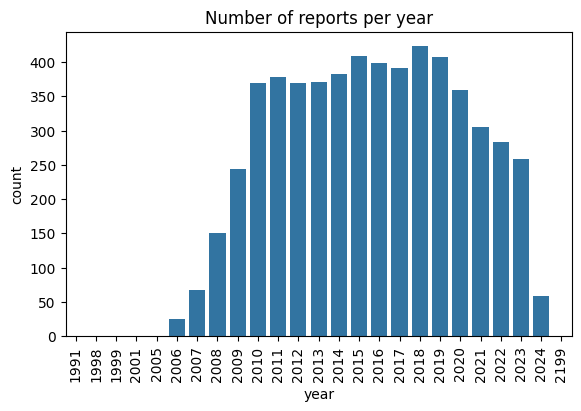

In [24]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))
ax = sns.countplot(x="year", data=pivoted_df, legend=False)

plt.title("Number of reports per year")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

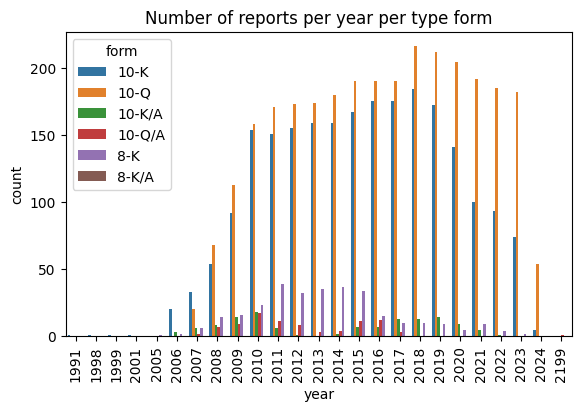

In [25]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))

form_order = ['10-K', '10-Q', '10-K/A', '10-Q/A', '8-K', '8-K/A']
ax = sns.countplot(x="year", data=pivoted_df ,hue="form", hue_order = form_order)

plt.title("Number of reports per year per type form")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

We can conclude that the majority of reports submitted per year are of type "10-Q". Let's remove from our analysis any entry poins before 2008 and after 2024 because they don't represent the distribution of the data, and/or they have very little entry points that could represent noise.
**Scope of our analysis from now on: 2008-2024**

In [26]:
staged_df_1 = pivoted_df[(pivoted_df["year"]>=2008) & (pivoted_df["year"]<=2024)]

In [27]:
entries_removed = pivoted_df.shape[0] - staged_df_1.shape[0]
print(f"We removed {entries_removed} entries")
print(f"Total number of entries now: {staged_df_1.shape[0]}")

We removed 98 entries
Total number of entries now: 5559


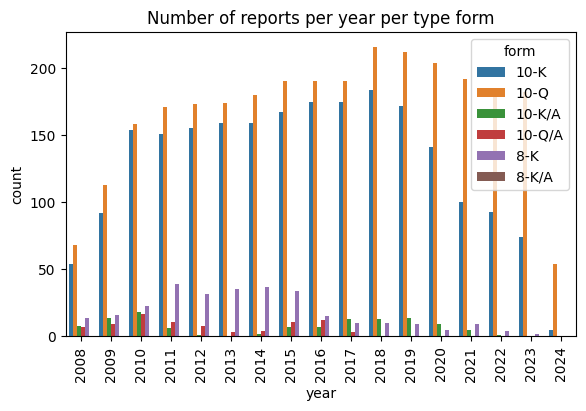

In [28]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))

form_order = ['10-K', '10-Q', '10-K/A', '10-Q/A', '8-K', '8-K/A']
ax = sns.countplot(x="year", data=staged_df_1 ,hue="form", hue_order = form_order)

plt.title("Number of reports per year per type form")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

Conclusions:
1. The number of reports submitted for our selected companies grew up until 2018, and then started to slowing decreasing.
2. In the time-spam of this analysis, 10-Q reports were the always the top type form submitted followed by 10-K

#### 2. Ticker

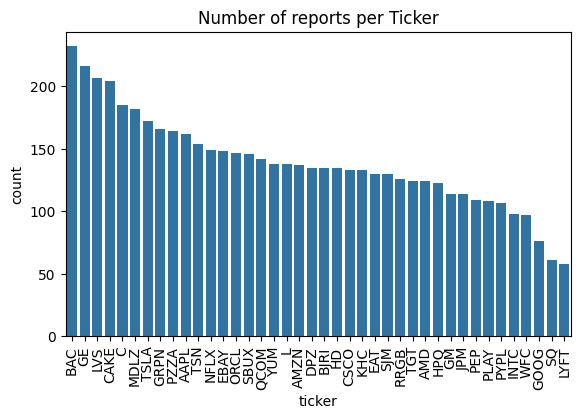

In [29]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))
ax = sns.countplot(x="ticker", data=staged_df_1, dodge=False, legend=False, order=staged_df_1['ticker'].value_counts().index)

plt.title("Number of reports per Ticker")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [30]:
# WEIRD RESULT: GOOGLE START TO BE TRADED IN 2004....Why do we have only date from 2012?
staged_df_1[staged_df_1["ticker"]=="GOOG"].year.unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024])

#### 3. Form

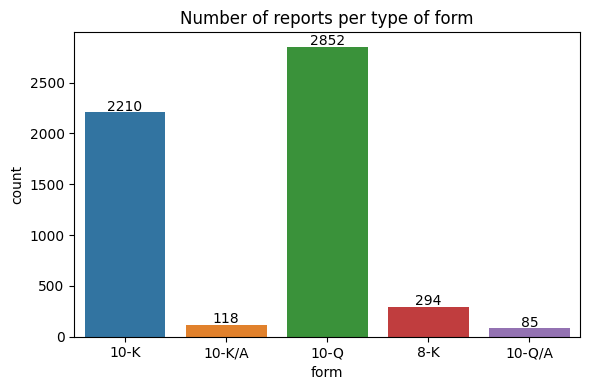

In [31]:
# Plotting the number of reports per type of form
plt.figure(figsize=(6,4))
ax = sns.countplot(x="form", data=staged_df_1, hue="form",dodge=False, legend=False)

# Add count values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 4), 
                textcoords = 'offset points')

plt.title("Number of reports per type of form")
plt.tight_layout()
plt.show()

It's surprising that the 10-Q-type forms are not 3x times the number of times of 10-K.

#### 4. Financial Accounts
Let's do some EDA on the high number of financial accounts used in our dataset

**Approaches**
1. Can we cluster the tickers based on the financial accounts used?
2. If not, can we consolidate the account columns based on word similarity using an encoding model like FinBert?
3. Filtering for a certain threshold of maximum % of nan-values per account

#### 1st approach: Can we cluster the tickers based on the financial accounts used?

In [32]:
account_columns = staged_df_1.columns[4:]
unique_accounts_per_ticker = staged_df_1.groupby('ticker')[account_columns].apply(lambda x: x.notna().any().sum()).sort_values()

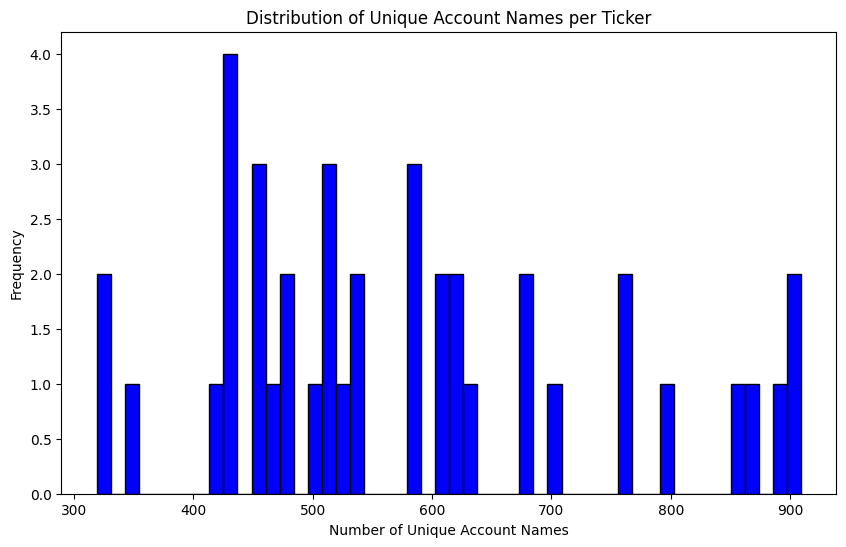

ticker
BJRI    319
LYFT    320
CAKE    345
PLAY    422
RRGB    429
DPZ     435
PYPL    435
HD      436
NFLX    452
LVS     456
SQ      460
GOOG    464
SJM     478
ORCL    482
AAPL    498
TGT     511
TSN     512
AMZN    513
EAT     524
PZZA    536
SBUX    543
YUM     581
PEP     582
GM      590
TSLA    607
EBAY    608
INTC    614
KHC     615
MDLZ    627
HPQ     674
QCOM    679
AMD     700
C       759
CSCO    760
L       795
GRPN    854
BAC     863
JPM     888
WFC     898
GE      909
dtype: int64


In [33]:
# Visualize the distribution of unique account names per ticker
plt.figure(figsize=(10, 6))
plt.hist(unique_accounts_per_ticker, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Unique Account Names per Ticker')
plt.xlabel('Number of Unique Account Names')
plt.ylabel('Frequency')
plt.show()

# Print the unique accounts per ticker for further inspection
print(unique_accounts_per_ticker)

The unique account names used by each ticker across our time-range is quite significant as it ranges from 321 and 912

In [34]:
# Clustering
# K-MEANS
binary_matrix = staged_df_1.groupby('ticker')[account_columns].apply(lambda df: df.notna().any()).astype(int)

In [35]:
# Evaluating the cluster definition
# Try different numbers of clusters
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(binary_matrix)
    silhouette_avg = silhouette_score(binary_matrix, clusters)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}')

Number of clusters: 2, Silhouette Score: 0.10
Number of clusters: 3, Silhouette Score: -0.01
Number of clusters: 4, Silhouette Score: -0.03
Number of clusters: 5, Silhouette Score: -0.01
Number of clusters: 6, Silhouette Score: -0.01
Number of clusters: 7, Silhouette Score: -0.00
Number of clusters: 8, Silhouette Score: 0.00
Number of clusters: 9, Silhouette Score: 0.00


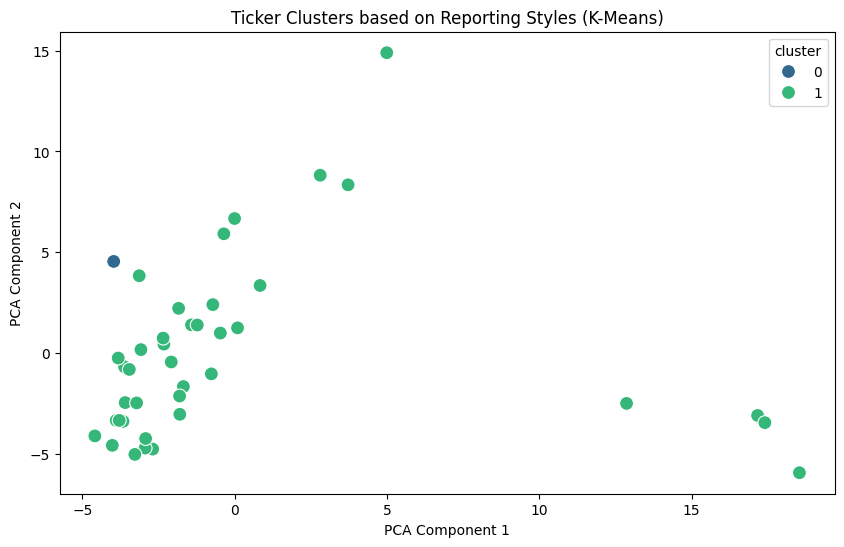

In [36]:
# Perform clustering
n_clusters = 2  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(binary_matrix)

# Add the cluster labels to the binary matrix for visualization
binary_matrix['cluster'] = clusters

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(binary_matrix.drop('cluster', axis=1))

# Create a DataFrame for visualization
visual_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])
visual_df['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x='pca1', y='pca2', hue='cluster', palette='viridis', s=100)
plt.title('Ticker Clusters based on Reporting Styles (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [37]:
binary_matrix[binary_matrix['cluster']==0]

account,AcceleratedShareRepurchaseProgramAdjustment,AcceleratedShareRepurchasesFinalPricePaidPerShare,AcceleratedShareRepurchasesSettlementPaymentOrReceipt,AccountsAndNotesReceivableNet,AccountsAndOtherReceivablesNetCurrent,AccountsNotesAndLoansReceivableNetCurrent,AccountsPayable,AccountsPayableAndAccruedLiabilitiesCurrent,AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent,AccountsPayableAndAccruedLiabilitiesFairValueDisclosure,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfShareOutstandingBasicAndDiluted,WeightedAverageNumberOfSharesContingentlyIssuable,WeightedAverageNumberOfSharesIssuedBasic,WeightedAverageNumberOfSharesOutstandingBasic,WeightedAverageNumberOfSharesRestrictedStock,WithdrawalFromContractHoldersFunds,WorkersCompensationLiabilityCurrent,WriteOffOfDeferredDebtIssuanceCost,cluster
ticker,,,,,,,,,,,,,,,,,,,,,
GRPN,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0


**Comments:**
- The K-Means resulted in suboptimal clustering of the tickers by the financial accounts used, it suggests that the current representation or clustering approach might not be capturing the underlying structure effectively.
- Nonetheless, the clustering GRPN is in a different cluster than the other ticker only based on the account names used.

Let's move to points 2 and 3:
- Use natural language processing techniques to consolidate similar account names.
- Reduce the dimensionality by filtering out features with high proportions of missing values.

#### 2nd approach: Consolidating accounts with NLP
1. Initially we tried to encode our account names using TF-IDF but the results were far from good.
2. We then used FinBert to encode our account names and to cluster them, as it is a model that was trained with a layer of financial corpus.

Encoding with FinBERT and Clustering

1. Output the account names as txt file
2. take the account_names.txt and run the jupyter notebook finBERT_Encoder.ipynb in Google Colab
4. the notebook will output a csv file with account names and its cluster
5. Read that csv file and in a new df consolidate the accounts

In [38]:
# Output the account names as txt file
with open('account_names.txt','w') as tfile:
	tfile.write('\n'.join(account_columns))

**ACTION: RUN THE finBERT_clusterer.ipynb in Google colab**

In [39]:
clustered_accounts_df = pd.read_csv("clustered_account_names.csv")

In [40]:
# Visualizing the results
print("Number of clusters generated:",clustered_accounts_df.cluster.nunique())
clustered_accounts_df[clustered_accounts_df["cluster"]==1][:20]

Number of clusters generated: 18


,account_name,cluster
86,AcquiredFiniteLivedIntangibleAssetAmount,1
87,AcquiredFiniteLivedIntangibleAssetWeightedAver...,1
88,AcquiredIndefiniteLivedIntangibleAssetAmount,1
150,AmortizationOfAcquiredIntangibleAssets,1
300,BusinessAcquisitionContingentConsiderationAtFa...,1
303,BusinessAcquisitionCostOfAcquiredEntityCashPaid,1
305,BusinessAcquisitionCostOfAcquiredEntityLiabili...,1
306,BusinessAcquisitionCostOfAcquiredEntityOtherNo...,1
307,BusinessAcquisitionCostOfAcquiredEntityPurchas...,1
308,BusinessAcquisitionCostOfAcquiredEntityTransac...,1


In [41]:
# Create a mapping dictionary from account names to clusters
account_to_cluster = dict(zip(clustered_accounts_df['account_name'], clustered_accounts_df['cluster']))

In [42]:
non_financial_cols = staged_df_1.columns[:4].tolist()
financial_cols = staged_df_1.columns[4:].tolist()

Let's use 1 technique of consolidation and see which one yields higher results in modeling compared to the next approach
1. Scaling each column and then summing the columns based on the clusters associated to

Let's use the industry's go-to algorithm: StandardScaler

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation

In [43]:
# Standardize financial columns
scaler = StandardScaler()
staged_df_2 = staged_df_1
staged_df_2.loc[:,financial_cols] = scaler.fit_transform(staged_df_2[financial_cols])

# Create a dictionary to store the consolidated columns
consolidated_data = {col: staged_df_2[col] for col in non_financial_cols}

# Aggregate standardized columns by cluster
for cluster in clustered_accounts_df['cluster'].unique():
    cluster_cols = [col for col in financial_cols if account_to_cluster[col] == cluster]
    consolidated_data[f'cluster_{cluster}'] = staged_df_1[cluster_cols].sum(axis=1)

# Create the consolidated DataFrame => Dataset 1
consolidated_df_scaled = pd.DataFrame(consolidated_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [44]:
consolidated_df_scaled.head()

,end_date,year,ticker,form,cluster_6,cluster_10,cluster_15,cluster_14,cluster_4,cluster_2,...,cluster_12,cluster_3,cluster_9,cluster_5,cluster_1,cluster_13,cluster_0,cluster_11,cluster_7,cluster_16
97,2008-01-01,2008,CAKE,10-K,0.00000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,-0.655198,0.000000,0.000000,0.0,-0.316606,0.000000,0.000000,0.0,0.000000
98,2008-01-31,2008,MDLZ,10-K,0.00000,-0.770163,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
99,2008-02-02,2008,TGT,10-K,0.08275,0.111972,0.0,-0.488593,0.0,2.155004,...,0.109336,-0.619683,0.231205,-0.604924,0.0,-0.416610,-0.695739,1.498061,0.0,-1.831594
100,2008-02-02,2008,TGT,10-K/A,0.08275,0.111972,0.0,-0.488593,0.0,2.155004,...,0.109336,-0.619683,0.231205,-0.604924,0.0,-0.416610,-0.695739,1.498061,0.0,-1.831594
101,2008-02-02,2008,TGT,10-Q,0.00000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,-0.463976,0.000000,0.000000,0.0,0.000000,-0.695739,0.000000,0.0,0.000000


#### 3rd approach: Filtering for a certain threshold of maximum % of nan-values per account

Let's explore the assumption that different reports might have different percentage of NaN values.

In [45]:
ten_k_df = staged_df_1[staged_df_1["form"]=="10-K"]
ten_q_df = staged_df_1[staged_df_1["form"]=="10-Q"]

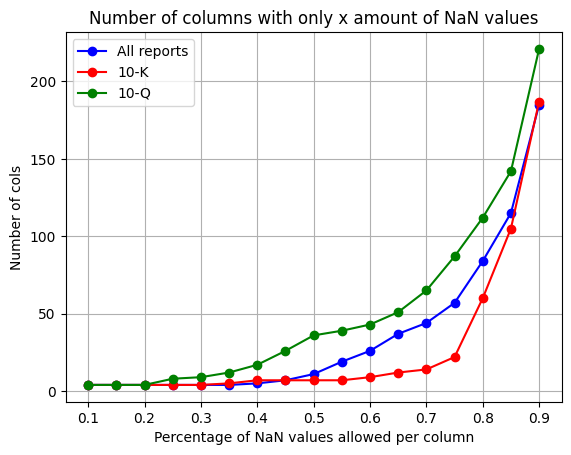

In [46]:
nr_cols_all = []
nr_cols_10_k = []
nr_cols_10_q = []

for i in np.arange(0.1,0.95,0.05):
    threshold = i.round(2)

    mask_all = (staged_df_1.isna().sum()/len(staged_df_1) <= threshold).to_list()
    nr_cols_all.append(len([staged_df_1.columns.to_list()[ind] for ind, col in enumerate(mask_all) if col==True]))
    
    mask_10_k = (ten_k_df.isna().sum()/len(ten_k_df) <= threshold).to_list()
    nr_cols_10_k.append(len([ten_k_df.columns.to_list()[ind] for ind, col in enumerate(mask_10_k) if col==True]))
    
    mask_10_q = (ten_q_df.isna().sum()/len(ten_q_df) <= threshold).to_list()
    nr_cols_10_q.append(len([ten_q_df.columns.to_list()[ind] for ind, col in enumerate(mask_10_q) if col==True]))
    
plt.title("Number of columns with only x amount of NaN values")
plt.xlabel("Percentage of NaN values allowed per column")
plt.ylabel("Number of cols")

plt.plot(np.arange(0.1, 0.95, 0.05), nr_cols_all, color="blue", label="All reports", marker='o')
plt.plot(np.arange(0.1, 0.95, 0.05), nr_cols_10_k, color="red", label="10-K", marker='o')
plt.plot(np.arange(0.1, 0.95, 0.05), nr_cols_10_q, color="green", label="10-Q", marker='o')

plt.legend()
plt.grid()
plt.show()

**Conclusions:**
- There is no financial account that is present in all reports of out dataset.
- The type of reports have different NaN values.
- As a second ideal scenario, we would be dealing with only columns with less than 10% of NaN values. However, the only columns that satisfy that requirement are the index columns. In fact, we only start seeing the financial account showing up at 23% of NaN values.
- The 10-Q report type contains less NaN values per column compared to 10-K and all reports all together.

Filtering for maximum of 50% NaN values per column in our staged_df_2 (2008-2024 all reports with scaled values) dataset

In [49]:
# Get the cols per type of report and threshold
filtered_df = staged_df_2 # ten_q_df, ten_k_df, staged_df_1
threshold = 0.5

mask = (filtered_df.isna().sum()/len(filtered_df) <= threshold).to_list()
cols= [filtered_df.columns.to_list()[ind] for ind, col in enumerate(mask) if col==True]
print("Number of financial cols:", len(cols)-4)
cols

Number of financial cols: 7


['end_date',
 'year',
 'ticker',
 'form',
 'Assets',
 'EarningsPerShareBasic',
 'EarningsPerShareDiluted',
 'LiabilitiesAndStockholdersEquity',
 'NetIncomeLoss',
 'RetainedEarningsAccumulatedDeficit',
 'StockholdersEquity']

#### Analyzing the distribution of the accounts filtered for

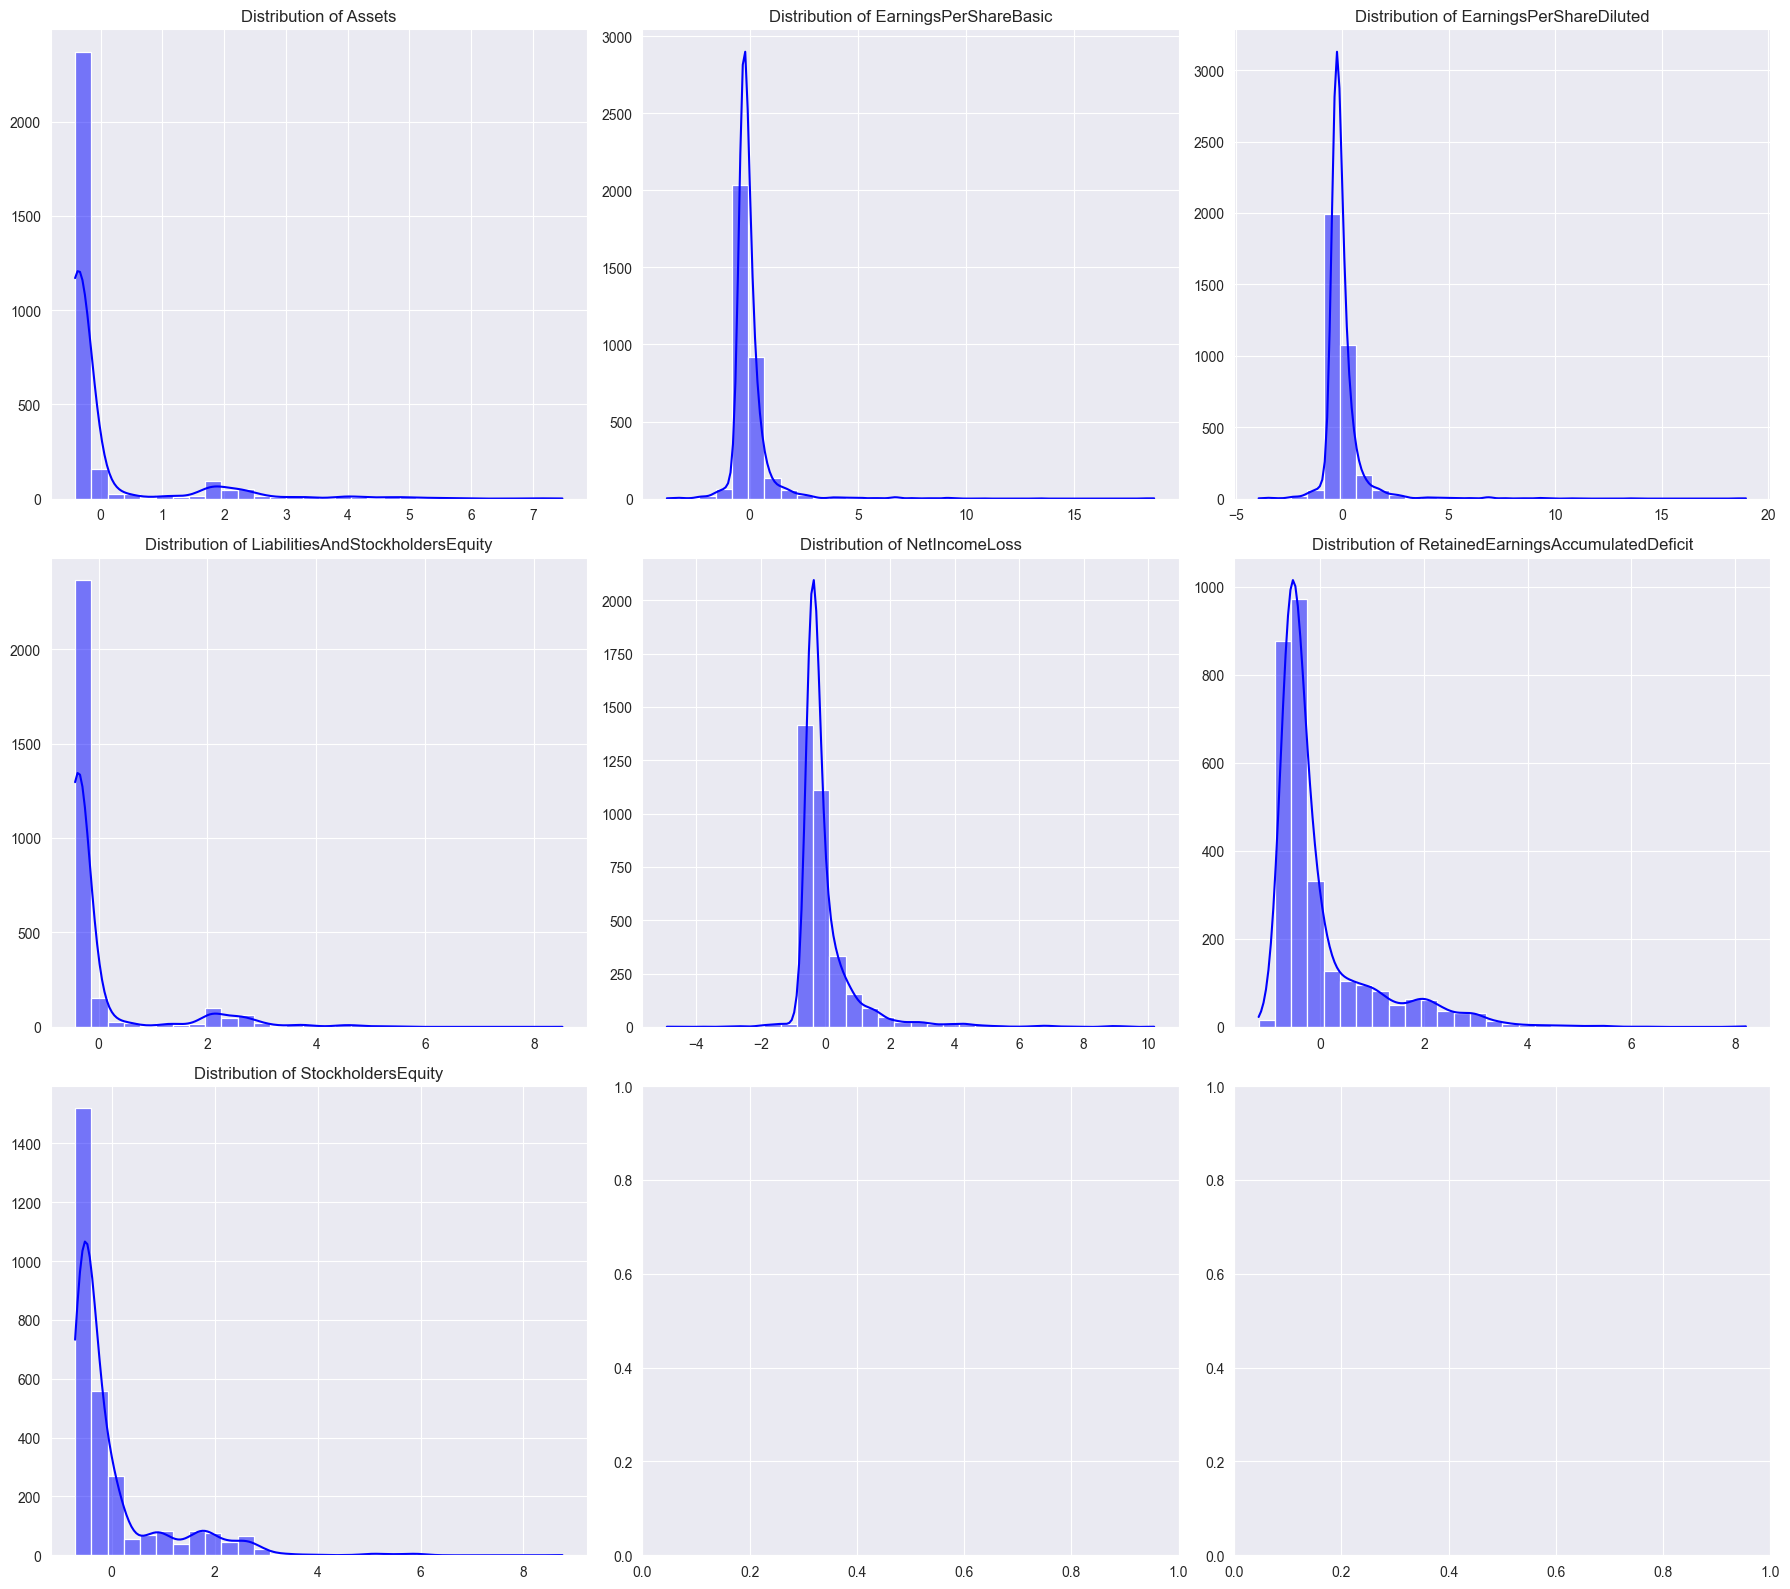

In [50]:
# Set the style
sns.set_style('darkgrid')

# Plot distributions of numerical variables
numerical_cols = cols[4:]

# Plot settings
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 16))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(filtered_df[col], bins=30, kde=True, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

**Comments**

Skewness: Many of the distributions appear to be highly skewed to the right (positively skewed). This means that most of the values are clustered near the lower end, with a long tail extending to the higher end.

Heavy Tails: The distributions have heavy tails, indicating the presence of outliers or extreme values. This is common in financial data where a few entities might have significantly higher values than the rest.

Log-Normal Distribution: The shape of these distributions suggests that the data might follow a log-normal distribution, which is common in financial datasets. Applying a log transformation could help in normalizing the data and making it more suitable for certain types of analysis or modeling.

**Recommendations for Feature Engineering**

- Log Transformation: Consider applying a log transformation to these features to reduce skewness and make the distributions more normal-like.

In [52]:
# Filtering => Dataset 2
filtered_df = filtered_df[cols]

### Adding a target column "anomaly" to our 2 datasets
As a binary classification.
We will have to merge the 2 data sources in order to determine if each report is anomalous or not.

Remember we have 2 datasets to prepare for our modeling notebook: consolidated_df_scaled and filtered_df

In [56]:
# with consolidated_df_scaled
merged_df_consolidated = consolidated_df_scaled.merge(anomaly_cases, how="left",left_on=["ticker","year"], right_on=["Anomaly Ticker","Scandal Year"], indicator=True)
merged_df_consolidated.drop(labels=["Scandal Year","Anomaly Ticker","cik_str"], axis=1, inplace=True)
merged_df_consolidated['anomaly'] = (merged_df_consolidated['_merge'] == 'both').astype(int)
merged_df_consolidated.drop(labels=["_merge"], axis=1, inplace=True)

In [58]:
merged_df_consolidated

,end_date,year,ticker,form,cluster_6,cluster_10,cluster_15,cluster_14,cluster_4,cluster_2,...,cluster_3,cluster_9,cluster_5,cluster_1,cluster_13,cluster_0,cluster_11,cluster_7,cluster_16,anomaly
0,2008-01-01,2008,CAKE,10-K,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.655198,0.000000,0.000000,0.000000,-0.316606,0.000000,0.000000,0.000000,0.000000,0
1,2008-01-31,2008,MDLZ,10-K,0.000000,-0.770163,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2008-02-02,2008,TGT,10-K,0.082750,0.111972,0.000000,-0.488593,0.000000,2.155004,...,-0.619683,0.231205,-0.604924,0.000000,-0.416610,-0.695739,1.498061,0.000000,-1.831594,1
3,2008-02-02,2008,TGT,10-K/A,0.082750,0.111972,0.000000,-0.488593,0.000000,2.155004,...,-0.619683,0.231205,-0.604924,0.000000,-0.416610,-0.695739,1.498061,0.000000,-1.831594,1
4,2008-02-02,2008,TGT,10-Q,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.463976,0.000000,0.000000,0.000000,0.000000,-0.695739,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5554,2024-04-21,2024,RRGB,10-Q,-0.636417,-4.660219,-6.487385,-7.358731,-0.866900,-2.332551,...,-1.789386,0.000000,0.000000,-0.783509,-3.488149,-0.383215,-0.692328,0.161686,-2.833028,0
5555,2024-04-27,2024,CSCO,10-Q,2.736663,7.607102,7.265723,13.397355,0.651182,-4.500226,...,1.847350,0.000000,-9.460123,16.411374,-7.586883,1.330999,-8.476478,-0.714930,0.503697,0
5556,2024-04-28,2024,HD,10-Q,-0.771520,-0.599259,3.798610,-1.571829,0.000000,4.126686,...,1.224673,0.000000,0.000000,-0.772041,6.466298,0.329913,2.374982,0.153819,-1.583729,0
5557,2024-04-30,2024,HPQ,10-Q,-2.316634,-4.377001,0.351019,-4.487990,-1.481367,-1.315890,...,-0.328794,-0.129194,0.000000,-0.743039,-4.772745,-1.105355,1.239368,-3.487482,-2.589455,0


In [59]:
# with filtered_df
merged_df_filtered = filtered_df.merge(anomaly_cases, how="left",left_on=["ticker","year"], right_on=["Anomaly Ticker","Scandal Year"], indicator=True)
merged_df_filtered.drop(labels=["Scandal Year","Anomaly Ticker","cik_str"], axis=1, inplace=True)
merged_df_filtered['anomaly'] = (merged_df_filtered['_merge'] == 'both').astype(int)
merged_df_filtered.drop(labels=["_merge"], axis=1, inplace=True)

In [60]:
merged_df_filtered

,end_date,year,ticker,form,Assets,EarningsPerShareBasic,EarningsPerShareDiluted,LiabilitiesAndStockholdersEquity,NetIncomeLoss,RetainedEarningsAccumulatedDeficit,StockholdersEquity,anomaly
0,2008-01-01,2008,CAKE,10-K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2008-01-31,2008,MDLZ,10-K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2008-02-02,2008,TGT,10-K,NaN,0.142288,0.148635,NaN,NaN,NaN,NaN,1
3,2008-02-02,2008,TGT,10-K/A,NaN,0.142288,0.148635,NaN,NaN,NaN,NaN,1
4,2008-02-02,2008,TGT,10-Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5554,2024-04-21,2024,RRGB,10-Q,-0.412894,-0.492941,-0.499031,-0.431771,-0.441216,-0.577942,-0.589394,0
5555,2024-04-27,2024,CSCO,10-Q,-0.270380,0.000240,0.005622,-0.270074,0.537196,-0.539366,-0.032064,0
5556,2024-04-28,2024,HD,10-Q,-0.321390,0.185382,0.197950,-0.327950,-0.089940,0.956367,-0.566891,0
5557,2024-04-30,2024,HPQ,10-Q,-0.370103,-0.098716,-0.096295,-0.383220,-0.261614,-0.617099,-0.600187,0


## Saving dataset for more Feature Engineering and Modeling Notebook

In [62]:
# Save the processed dataframe to a CSV file
output_file_path = 'data/staged/staged_model_data_consolidated.csv'
merged_df_consolidated.to_csv(output_file_path, index=False)

print(f"Processed dataframe saved to {output_file_path}")

output_file_path = 'data/staged/staged_model_data_filtered.csv'
merged_df_filtered.to_csv(output_file_path, index=False)

print(f"Processed dataframe saved to {output_file_path}")

Processed dataframe saved to data/staged/staged_model_data_consolidated.csv
Processed dataframe saved to data/staged/staged_model_data_filtered.csv
